In [1]:
import pandas as pd
from datetime import datetime
import tqdm as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='Progress')
import sklearn
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [9]:
df = pd.read_csv('~/insight/Data Challenges/employee_retention_data.csv')

In [10]:
# convert date strings to usable dates
def make_time(string):
    if type(string) == float:
        return np.NaN
    return datetime.strptime(string, '%Y-%m-%d')


# make column for if the employee left or not
def quit(string):
    if type(string) == float:
        return 0
    else:
        return 1
    
df['quit'] = df['quit_date'].apply(quit)
df['join_date'] = df['join_date'].apply(make_time)
df['quit_date'] = df['quit_date'].apply(make_time)


# change from datetime
def to_days(td):
    return td.days


df['days_employed'] = df['quit_date'] - df['join_date']
df['days_employed'] = df['days_employed'].apply(to_days)

df['employee_id'] = df['employee_id'].astype(int)
df['salary'] = df['salary'].astype(int)
df['seniority'] = df['seniority'].astype(int)


# change two seniority years (98 and 99) to avg, presuming erroneous
def check_seniority(num):
    if num > 90:
        return senior_mean
    else:
        return num

senior_mean = int(df['seniority'].mean())    
df['seniority'] = df['seniority'].apply(check_seniority)

# make categorical column for seniority
def senior_cat(num):
    if num < 5:
        return 'entry'
    if num >= 5:
        if num <= 15:
            return 'mid'
        else:
            return 'senior'

df['senior_cat'] = df['seniority'].apply(senior_cat)

# make ordinal column for dept
df['dept_num'] = LabelEncoder().fit_transform(df['dept'])

def senior_ord(num):
    if num < 5:
        return 1
    if num >= 5:
        if num <= 15:
            return 2
        else:
            return 3

df['senior_ord'] = df['seniority'].apply(senior_ord)

In [11]:
# get some descriptive stats for salary differences between employees

import scipy
from scipy import stats

a = df['salary'][df['quit']==0]
b = df['salary'][df['quit']==1]

print('Salary differences: \n')
print('mean of non-quitters: \n' + str(round(a.mean(), 2)))
print('mean of quitters: \n' + str(round(b.mean(), 2)))
print('\nmedian of non-quitters: \n' + str(round(a.median(), 2)))
print('median of quitters: \n' + str(round(b.median(), 2)))
print('\nDifference between groups:\np = ' + str(round(scipy.stats.ttest_ind(a,b).pvalue, 10)))

Salary differences: 

mean of non-quitters: 
141238.47
mean of quitters: 
135652.41

median of non-quitters: 
123000.0
median of quitters: 
122000.0

Difference between groups:
p = 9e-09


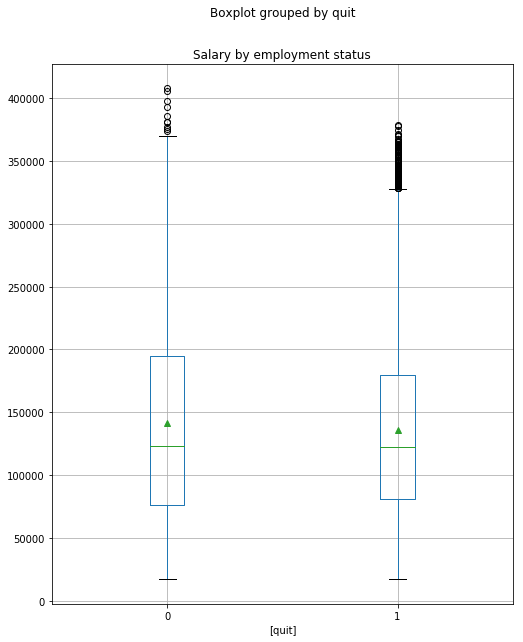

In [12]:
ax = df.boxplot(column=['salary'], by=['quit'], figsize=(8,10), showmeans=True)
ax = ax.set_title("Salary by employment status")

## Salary differences between those who quit vs stay exist within certain departments: Data Science and Engineering

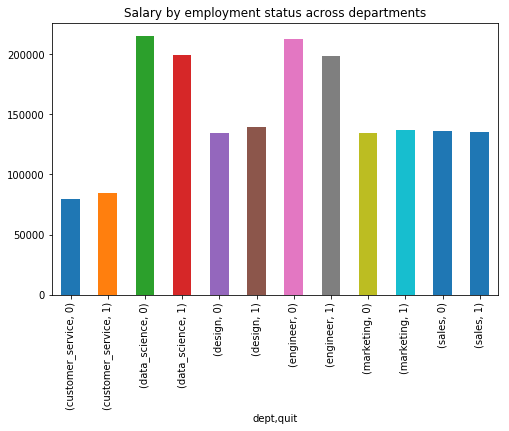

In [13]:
ax = df.groupby(['dept', 'quit'])['salary'].mean().plot(kind='bar', figsize=(8,5), title='Salary by employment status across departments')

## Not due to more senior members within those departments:

In [14]:
c = df['seniority'][df['quit']==0]
d = df['seniority'][df['quit']==1]

print('Seniority differences: \n')
print('mean of non-quitters: \n' + str(round(c.mean(), 3)))
print('mean of quitters: \n' + str(round(d.mean(), 3)))

Seniority differences: 

mean of non-quitters: 
14.123
mean of quitters: 
14.119


## Noticeable discrepancy between salaries for those who quit vs those who don't, at the senior level

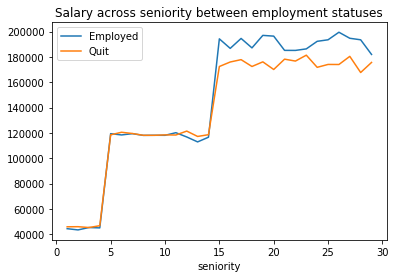

In [15]:
#fig, ax = plt.subplots(figsize=(8,6))
ax = df[df['quit']==0].groupby(['seniority'])['salary'].mean().plot.line(label='Employed', legend=True, title='Salary across seniority between employment statuses')
ax = df[df['quit']==1].groupby(['seniority'])['salary'].mean().plot.line(label='Quit', legend=True, ax=ax)

## Paying employees based on average salary of individuals who have not left could save money in the long run

In [16]:
# calculate numbers for salaries of those who quit vs not
cols4 = ['salary','dept','senior_cat']
df_employed = df[cols4][df['quit']==0].groupby(by=['dept','senior_cat']).mean()
df_employed = df_employed.rename({'salary': 'salary_employed'}, axis='columns')

df_quit = df[cols4][df['quit']==1].groupby(by=['dept','senior_cat']).mean()
df_quit = df_quit.rename({'salary': 'salary_quit'}, axis='columns')

# add counts for each group
df_employed['n_employed'] = df[cols4][df['quit']==0].groupby(by=['dept','senior_cat']).count()
df_quit['n_quit'] = df[cols4][df['quit']==1].groupby(by=['dept','senior_cat']).count()

df_info = pd.concat([df_employed, df_quit], sort=True, axis=1)

df_info['salary_diff'] = df_info['salary_employed'] - df_info['salary_quit']
df_info['payroll_change'] = df_info['n_quit'] * df_info['salary_diff']

# calculate what changing salaries would cost overall

payroll_cost = df_info['payroll_change'].sum()
replace_cost = (df_info['n_quit'].sum())*100000

print('New payroll cost: \n' + '$' + str('{:,}'.format(int(payroll_cost))))
print('\n')
print('Current replacement cost (conservatively at $100k/person): \n' + '$' + str('{:,}'.format(round(replace_cost,2))))
print('\n')
print('Savings: \n' + '$' + str('{:,}'.format(int(replace_cost - payroll_cost))))

New payroll cost: 
$28,595,694


Current replacement cost (conservatively at $100k/person): 
$1,351,000,000


Savings: 
$1,322,404,305


In [17]:
# one hot encode categorical variables and combine into a dataframe
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['dept'])
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

temp_dept = pd.DataFrame(onehot_encoded, columns = label_encoder.classes_)

integer_encoded = label_encoder.fit_transform(df['senior_cat'])
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

temp2 = pd.DataFrame(onehot_encoded, columns = label_encoder.classes_)

df_onehot = pd.concat([df, temp2],sort=True, axis=1)
df_onehot2 = pd.concat([df_onehot, temp_dept], sort=True, axis=1)

In [18]:
# focus on certain variables for modeling
model_cols = ['entry', 'mid', 'senior', 'quit', 'days_employed',
             'salary', 'customer_service', 'data_science', 'design',
         'engineer', 'marketing', 'sales']

df_model = df_onehot2[model_cols]

xcols = ['salary', 'customer_service', 'data_science', 'design',
         'engineer', 'marketing', 'sales', 'entry', 'mid', 'senior']
#xcols = ['dept_num','senior_ord','salary']
ycol = ['quit']
y = np.ravel(df_model[ycol])
X = df_model[xcols]

In [19]:
# split into test/train groups
# normalize values for logistic regression coefficient interpretability
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    StandardScaler().fit_transform(X), y, test_size=0.33)
#        X, y, test_size=0.33, random_state=0)

/Users/ckm/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ckm/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
from sklearn.linear_model import LogisticRegression
clfLR = LogisticRegression(solver='lbfgs').fit(X_train,y_train)
print('Accuracy: ' + str(round(clfLR.score(X_test,y_test),4)))
print('Training accuracy: ' + str(round(clfLR.score(X_train,y_train), 4)))

Accuracy: 0.5575
Training accuracy: 0.5639


In [29]:
from sklearn.metrics import r2_score
y_pred = clfLR.predict(X_test)
print('R-squared: ' + str(round(r2_score(y_test, y_pred),4)))

R-squared: -0.7835


In [31]:
from sklearn.ensemble import RandomForestClassifier
clfRF = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print('Accuracy: ' + str(round(clfRF.score(X_test,y_test),4)))
print('Training Accuracy: ' + str(round(clfRF.score(X_train,y_train),4)))

Accuracy: 0.5363
Training Accuracy: 0.6306


# Ultimately, the effect of underpaying workers is not confirmed through modeling